## Aryan Shah<br>aryanshah1902@gmail.com<br><br>+1 630 398 1046

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from noise import snoise2
import cv2
import random
import time
import concurrent.futures

### Questions
## 1. Come up with efficient data structures to represent both types of images: those generated by the microscope, and those generated by the dye sensor. These need not have the same representation; the only requirement is that they be compact and take as little storage space as possible. Explain why you picked the representation you did for each image type, and if possible estimate how much storage would be taken by the images. What is the worst-case storage size in bytes for each image representation you chose?

### **Data Structure for Efficient Image Storage**

#### **1. Blob (Parasite) Image Storage:**

- **Data Structure:** A list of `(x, y)` tuples representing coordinates of black pixels.
- Assuming the blob takes up 30% of an image on average
 **Worst-case Storage Calculation:** 
  - Approximated as:
  `(0.3) * (100,000 * 100,000) * 2 * int size`
  Where `int size` is typically 4 bytes (size of an integer).

#### **2. Dye Sensor Image Storage:**

- **Data Structure:** A list of `(x, y)` tuples representing coordinates of white pixels (dye).
- **Worst-case Storage:** The storage need will typically be less than:
  - `(0.3) * (100,000 * 100,000) * 2 * int size`
  depending on the dye dispersion in the image.

### **Method for Retrieval and Cancer Detection:**

#### **- Overlap Calculation:**
  - Dye within blob = Blob coordinates INTERSECTION Dye coordinates
#### **- Cancer Detection:**
  - If `(len(Dye within blob) / len(Blob coordinates)) > 0.1`, cancer is detected.

### **Potential Optimizations:**

#### **- Coordinate Compression:**
Utilize schemes like run-length encoding if patterns or contiguous pixels are observed.

#### **- Differential Encoding:**
Store only the differences for sequential, similar images, after storing the first image fully.

### **Analysis:**

This strategy aims to minimize storage by preserving only necessary pixel information and avoiding storage of uniform and non-informative parts of the image. While the computational requirement might increase during data retrieval and visualization due to decompression and reformatting, this trade-off is often favorable in scenarios dealing with massive datasets and constrained storage capacities.

### 2. Before the researchers give you real images to work with, you would like to test out any code you write. To this end, you would like to create “fake” simulated images and pretend they were captured by the microscope and the dye sensor. Using the data structures you chose in (1) above, write code to create such simulated images. Try and be as realistic in the generated images as possible.

In [2]:
def generate_blob(img_size=(100, 100), target_ratio=0.25):
    img = np.ones(img_size) * 255
    mask = np.zeros(img_size, dtype=np.uint8) 

    num_points = 5
    points = np.random.randint(0, min(img_size), (num_points, 2))

    hull = cv2.convexHull(points)
    cv2.drawContours(mask, [hull], 0, (255), thickness=cv2.FILLED)

    while np.sum(mask) / 255 / (img_size[0] * img_size[1]) < target_ratio:
        mask = cv2.dilate(mask, (3, 3))
    mask = cv2.erode(mask, (5, 5), iterations=5)
    mask = cv2.GaussianBlur(mask, (35, 35), sigmaX=8, sigmaY=8)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    img = np.where(mask==255, 0, img).astype(np.uint8)

    return img

def generate_dye(mask, internal_dye_percentage=0.15, leakage_percentage=0.01):
    dye_image = np.zeros_like(mask)
    
    # Get the coordinates of the parasite blob
    y_blob, x_blob = np.where(mask == 0)
    
    # Determine the number of dye pixels to place in the blob
    num_dye_pixels_blob = int(len(x_blob) * internal_dye_percentage)
    
    # Randomly select a subset of blob pixels to be turned into dye
    dye_indices_blob = np.random.choice(range(len(x_blob)), num_dye_pixels_blob, replace=False)
    
    for idx in dye_indices_blob:
        dye_image[y_blob[idx], x_blob[idx]] = 255
    
    # Get the coordinates of the whole image
    y_total, x_total = np.where(mask >= 0)  # every pixel
    
    # Determine the number of dye pixels to place in the image for leakage
    num_dye_pixels_total = int(len(x_total) * leakage_percentage)
    
    # Randomly select a subset of image pixels to be turned into dye, simulating leakage
    dye_indices_total = np.random.choice(range(len(x_total)), num_dye_pixels_total, replace=False)
    
    for idx in dye_indices_total:
        # If it overlaps with previously placed dye, skip it
        if dye_image[y_total[idx], x_total[idx]] == 255:
            continue
        dye_image[y_total[idx], x_total[idx]] = 255
    
    return dye_image

In [21]:
def calculate_and_visualize_overlap(blob_img, dye_img, threshold=0.10):
    dye_in_blob = np.bitwise_and(dye_img, np.invert(blob_img))
    blob_area = np.sum(blob_img == 0)
    dye_in_blob_area = np.sum(dye_in_blob == 255)
    
    percentage_dye = (dye_in_blob_area / blob_area) * 100
    
    color_overlay = np.zeros((blob_img.shape[0], blob_img.shape[1], 3), dtype=np.uint8)
    color_overlay[blob_img == 0] = [0, 0, 0]  # Black for blob
    color_overlay[dye_in_blob == 255] = [0, 0, 255]  # Blue for dye in blob
    

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(blob_img, cmap='gray')
    axs[0].set_title("Blob")
    axs[1].imshow(dye_img, cmap='gray')
    axs[1].set_title("Dye")
    axs[2].imshow(color_overlay)
    axs[2].set_title(f"Overlay: Dye is {percentage_dye:.2f}% of Blob")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    has_cancer = percentage_dye > (threshold * 100)
    
    return has_cancer

## Simulation

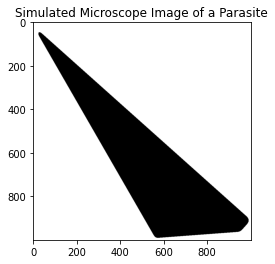

In [4]:

blob_img = generate_blob(img_size=(1000, 1000), target_ratio=0.25)

plt.imshow(blob_img, cmap='gray')
plt.title("Simulated Microscope Image of a Parasite")
plt.show()


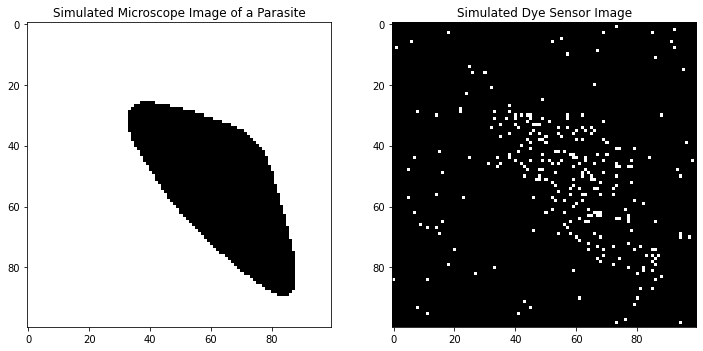

In [5]:
# Example Usage
blob_img = generate_blob(img_size=(100, 100), target_ratio=0.25)

# Generate dye image using the blob as a mask
dye_img = generate_dye(blob_img, internal_dye_percentage=0.09, leakage_percentage=0.01 )

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(blob_img, cmap='gray')
axs[0].set_title("Simulated Microscope Image of a Parasite")
axs[1].imshow(dye_img, cmap='gray')
axs[1].set_title("Simulated Dye Sensor Image")
plt.show()

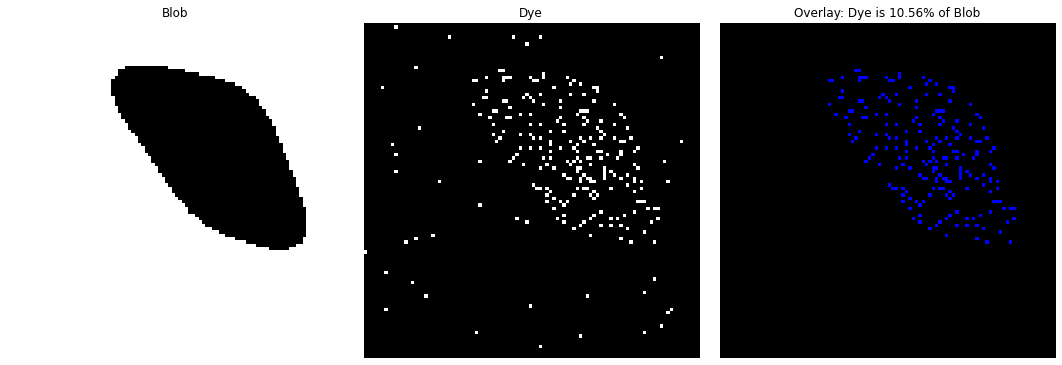

The parasite has cancer.


In [6]:
blob_img = generate_blob(img_size=(100, 100), target_ratio=0.25)
dye_img = generate_dye(blob_img, internal_dye_percentage=0.1, leakage_percentage=0.005)
has_cancer = calculate_and_visualize_overlap(blob_img, dye_img, threshold=0.10)

if has_cancer:
    print("The parasite has cancer.")
else:
    print("The parasite does not have cancer.")

## 3. Using the simulated images generated by the code you wrote for (2) above as input, write a function to compute whether a parasite has cancer or not.


- It is nearly impractical to generate images of more than (100,100) on personal computers so we are using the images of (100,100) for the time being, but the approach would hold true for bigger image sizes as well.

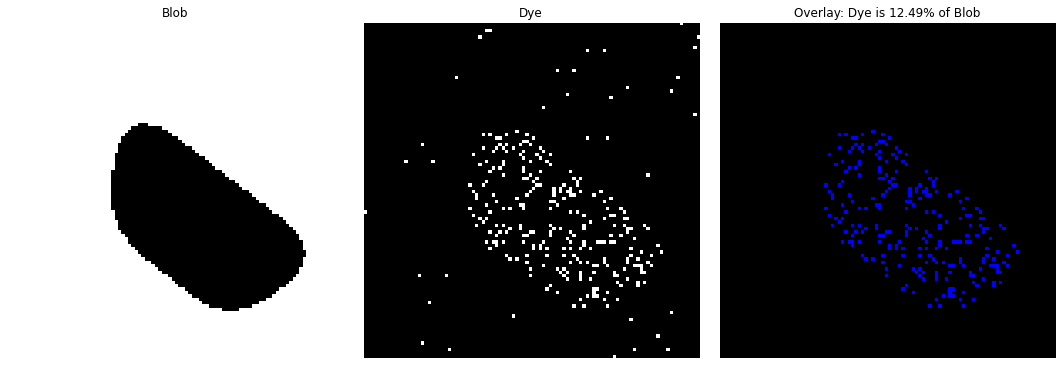

The parasite has cancer.


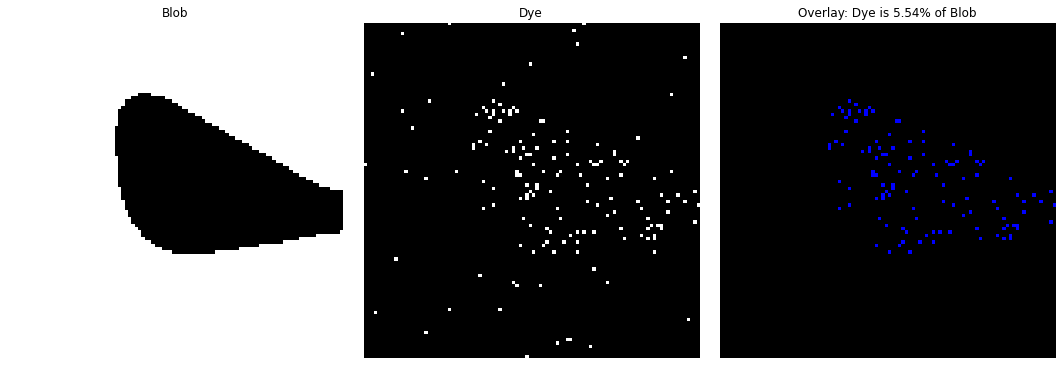

The parasite does not have cancer.


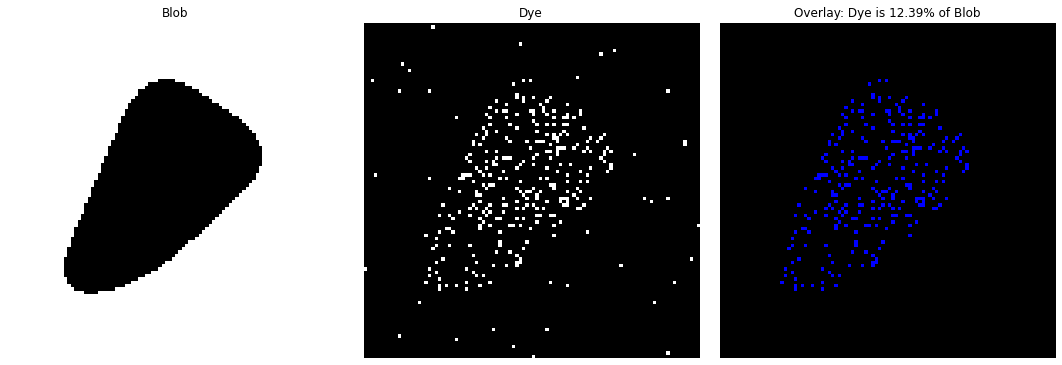

The parasite has cancer.


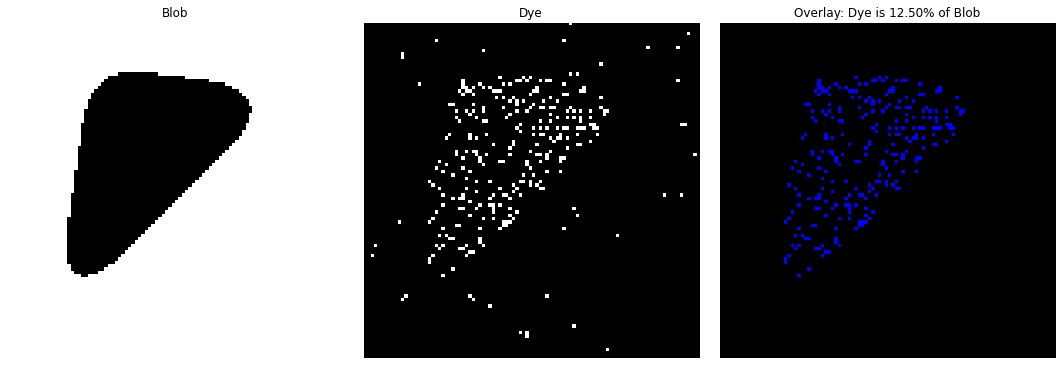

The parasite has cancer.


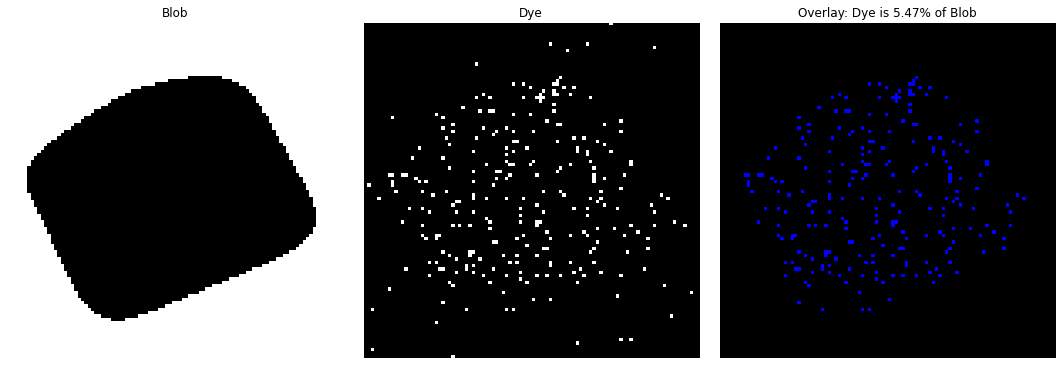

The parasite does not have cancer.


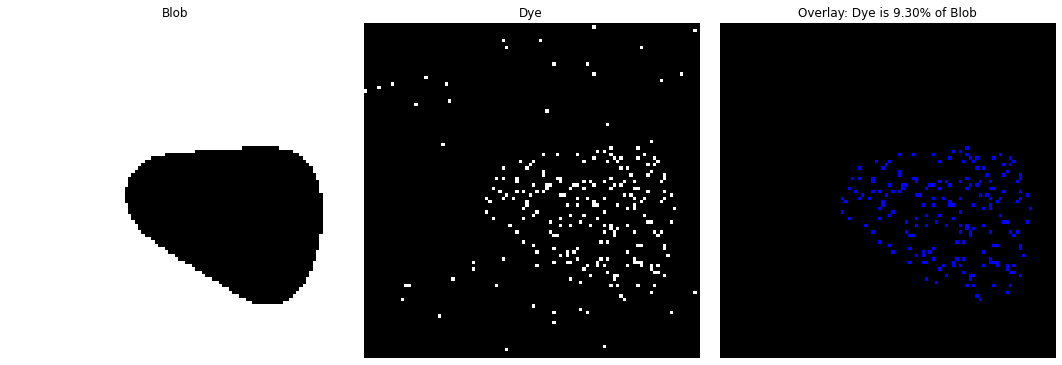

The parasite does not have cancer.


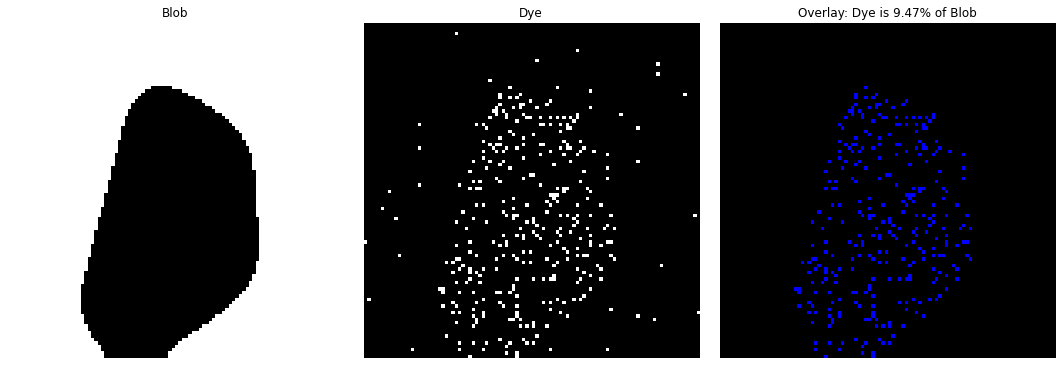

The parasite does not have cancer.


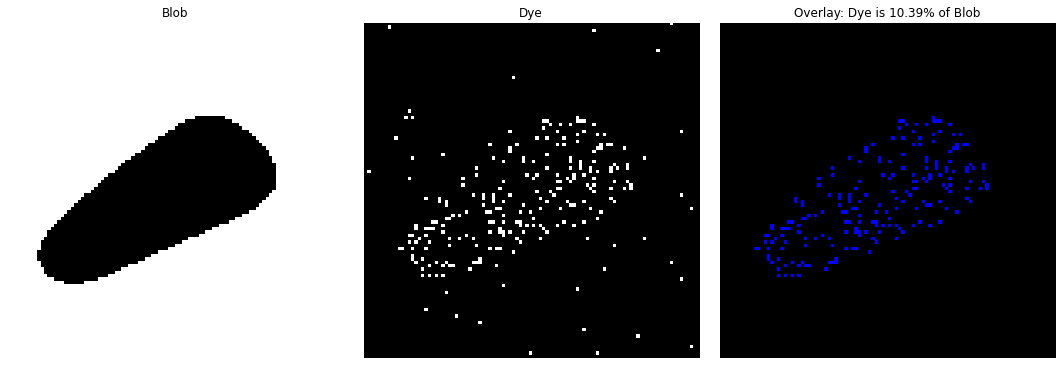

The parasite has cancer.


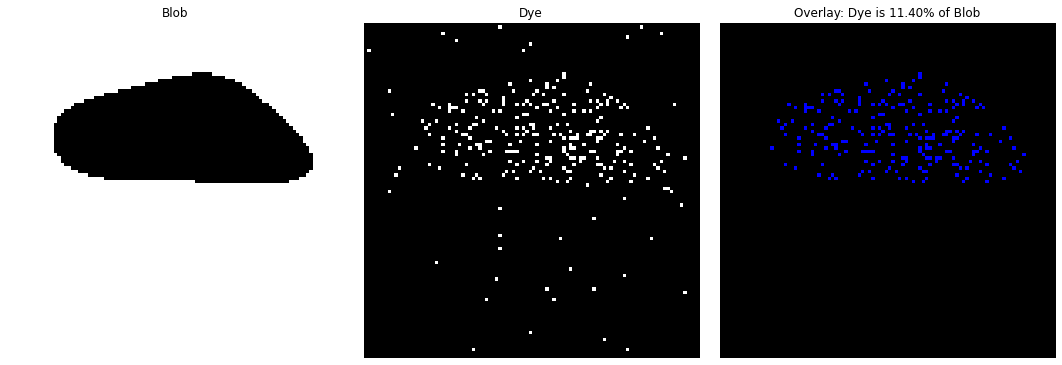

The parasite has cancer.


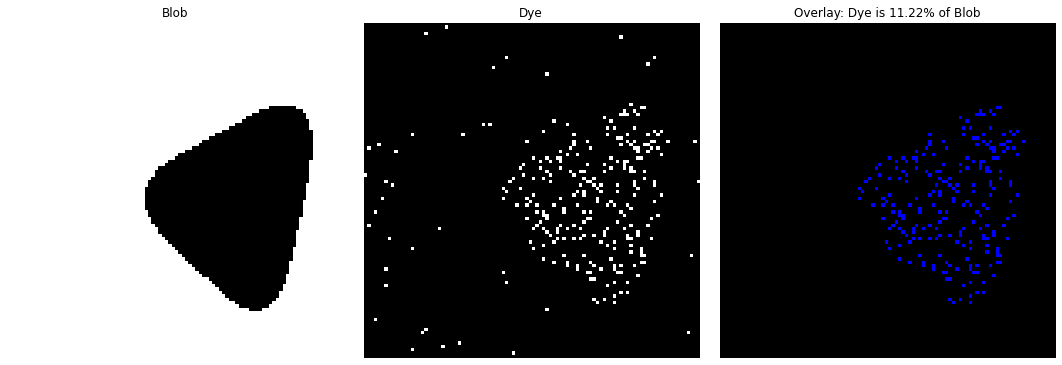

The parasite has cancer.


In [23]:
start_time = time.time()
for i in range(10):
    dye = random.randint(5,12)/100
    blob_img = generate_blob(img_size=(100, 100), target_ratio=0.25)
    dye_img = generate_dye(blob_img, internal_dye_percentage= dye, leakage_percentage=0.005)
    has_cancer = calculate_and_visualize_overlap(blob_img, dye_img, threshold=0.10)

    if has_cancer:
        print("The parasite has cancer.")
    else:
        print("The parasite does not have cancer.")
end_time = time.time()

In [24]:
print(f"Processing took {end_time - start_time:.10f} seconds")


Processing took 1.8442728519 seconds


## 4. You give your code from (3) to the researchers, who run it and find that it is running too slowly for their liking. What can you do to improve the execution speed? Write the code to implement the fastest possible version you can think of for the function in (3).

### ### Here we are only preserving the information of the area of the blob in both blob and dye saving over 40-50% of image data.

In [25]:
def calculate_and_visualize_overlap(blob_img, dye_img, threshold=0.10):
    dye_in_blob = np.bitwise_and(dye_img, np.invert(blob_img))
    blob_area = np.sum(blob_img == 0)
    dye_in_blob_area = np.sum(dye_in_blob == 255)
    
    percentage_dye = (dye_in_blob_area / blob_area) * 100
    
    color_overlay = np.zeros((blob_img.shape[0], blob_img.shape[1], 3), dtype=np.uint8)
    color_overlay[blob_img == 0] = [0, 0, 0]  # Black for blob
    color_overlay[dye_in_blob == 255] = [0, 0, 255]  # Blue for dye in blob
    
    # Creating a mask for the visualization such that only the blob and dye areas are displayed
    mask_blob_and_dye = np.bitwise_or(blob_img == 0, dye_in_blob == 255)
    
    # The mask should exclude (make white) all areas that are not part of the blob or dye
    color_overlay[np.bitwise_not(mask_blob_and_dye)] = [255, 255, 255]  

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(blob_img, cmap='gray')
    axs[0].set_title("Blob")
    axs[1].imshow(dye_img, cmap='gray')
    axs[1].set_title("Dye")
    axs[2].imshow(color_overlay)
    axs[2].set_title(f"Overlay: Dye is {percentage_dye:.2f}% of Blob")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    has_cancer = percentage_dye > (threshold * 100)
    
    return has_cancer

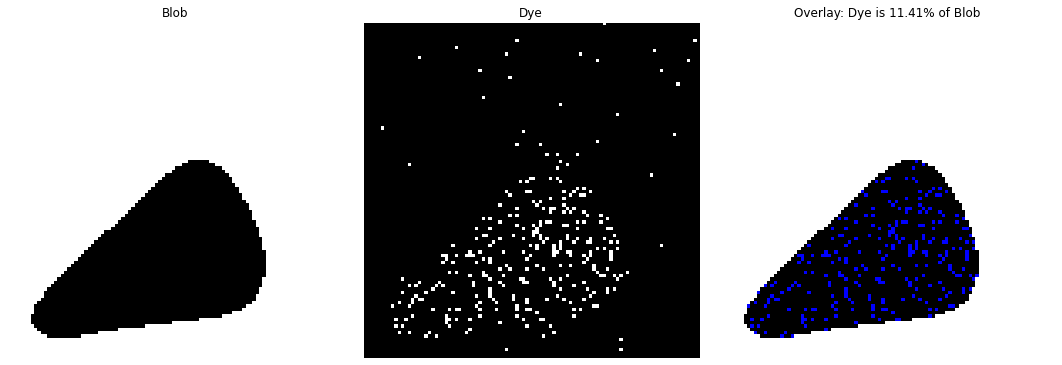

The parasite has cancer.


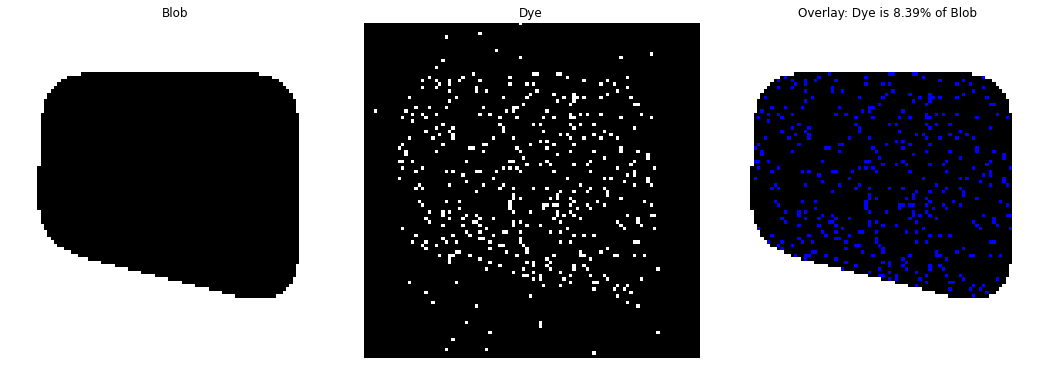

The parasite does not have cancer.


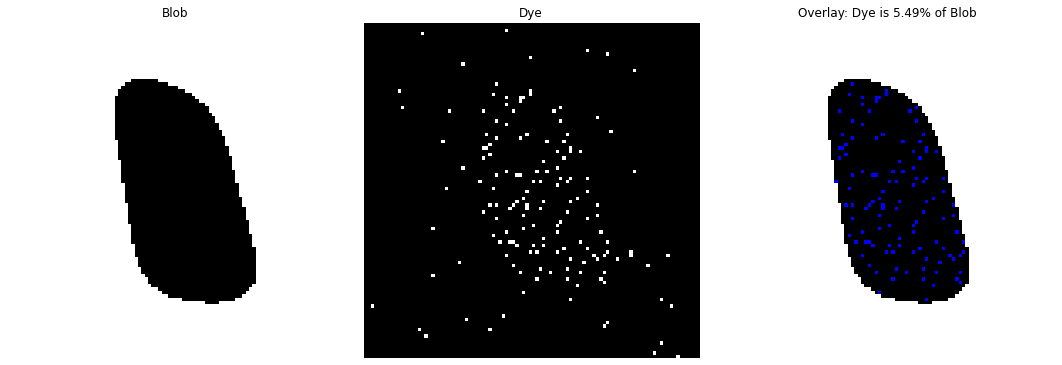

The parasite does not have cancer.


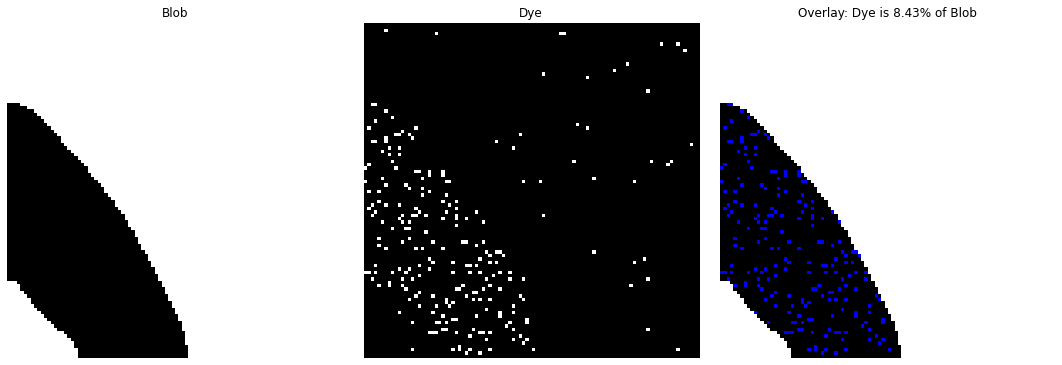

The parasite does not have cancer.


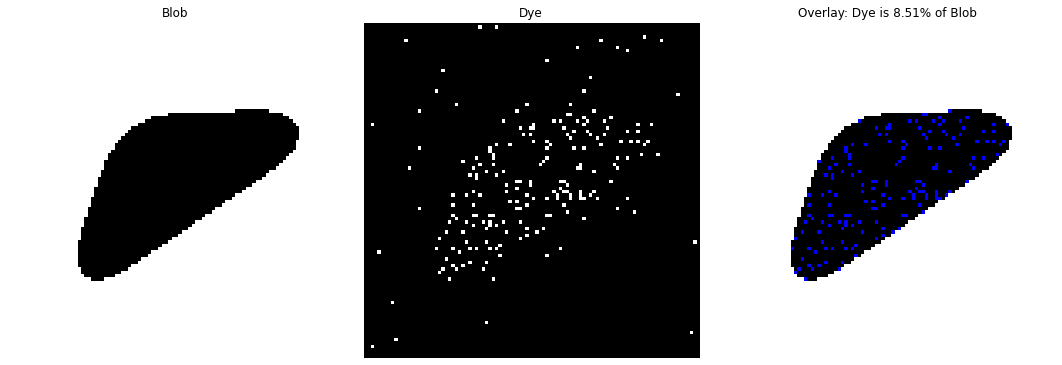

The parasite does not have cancer.


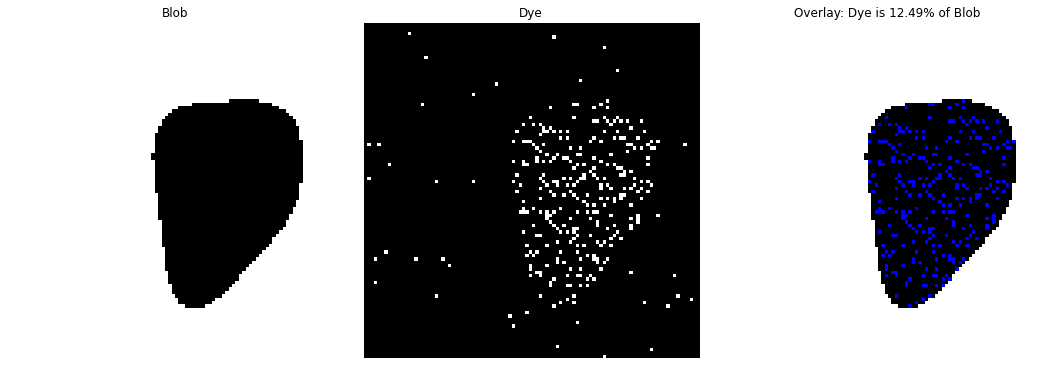

The parasite has cancer.


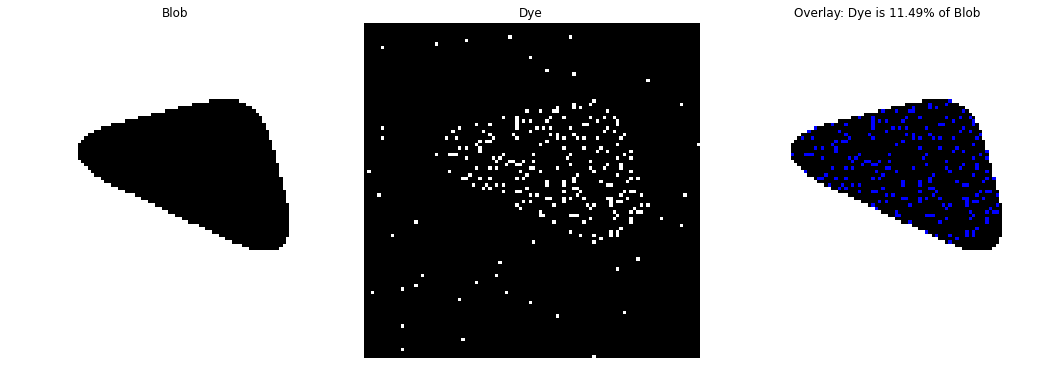

The parasite has cancer.


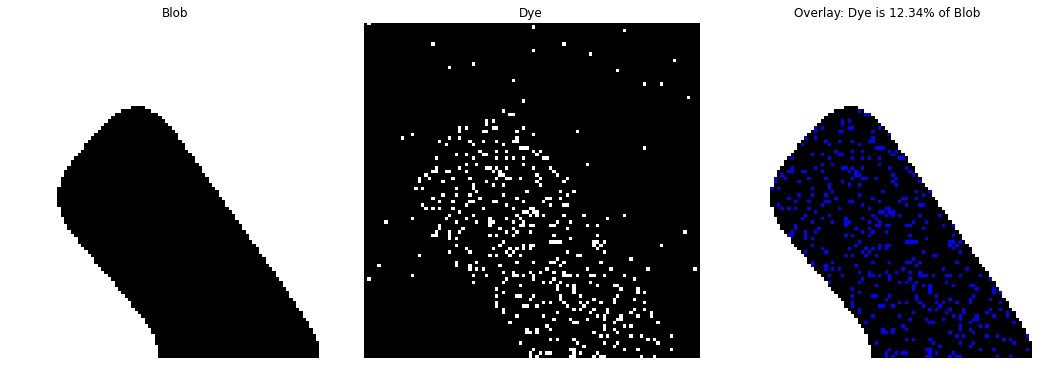

The parasite has cancer.


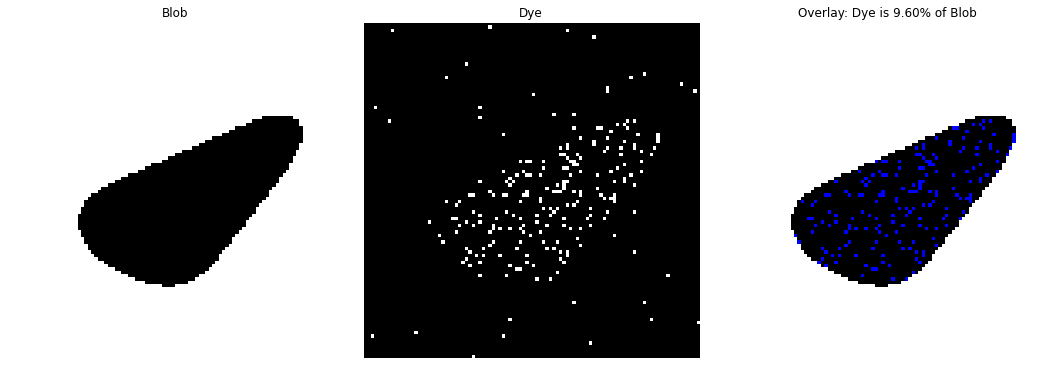

The parasite does not have cancer.


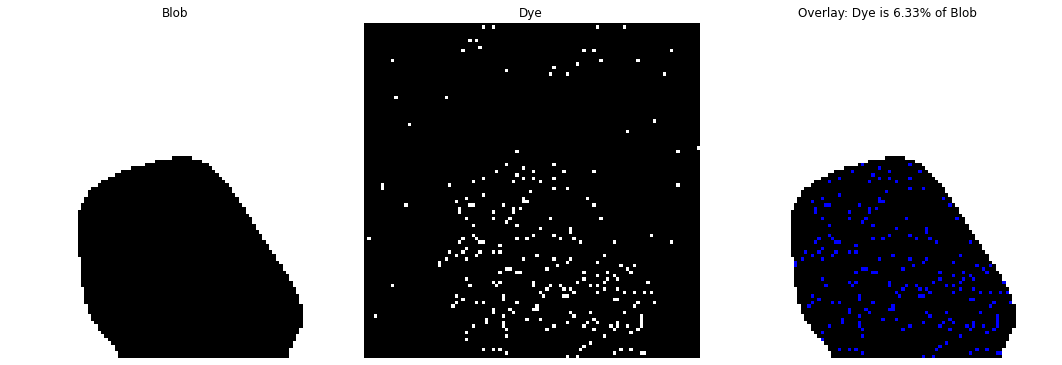

The parasite does not have cancer.


In [31]:
start_time = time.time()
for i in range(10):
    dye = random.randint(5,12)/100
    blob_img = generate_blob(img_size=(100, 100), target_ratio=0.25)
    dye_img = generate_dye(blob_img, internal_dye_percentage= dye, leakage_percentage=0.005)
    has_cancer = calculate_and_visualize_overlap(blob_img, dye_img, threshold=0.10)

    if has_cancer:
        print("The parasite has cancer.")
    else:
        print("The parasite does not have cancer.")
end_time = time.time()

In [32]:
print(f"Processing took {end_time - start_time:.10f} seconds")


Processing took 1.8482508659 seconds


### We can see that the processing took much less time here because there was a lot of less data as well as less area to compute

## 5. Describes what tools you used to solve the challenge, particularly any LLM techniques.

### Tools and Techniques Employed:

#### 1. **Image Generation and Manipulation**
   - **Tool/Module:** OpenCV and NumPy
   - **Techniques:**
     - Utilizing NumPy for array manipulations and creating image masks.
     - Using OpenCV for drawing shapes, managing image data, and for visual analysis through plots.

#### 2. **Data Representation and Visualization**
   - **Tool/Module:** Matplotlib
   - **Techniques:**
     - Used to visualize generated images and to provide comparative visuals of the generated blobs and dye distribution.
     - Employed for overlaying color masks to highlight regions of interest (e.g., dye within the parasite blob).

#### 3. **Logical Structuring and Data Management**
   - **Technique:** Conditional Logic and Loop Structures
   - **Approach:**
     - Used loops to create repetitions in image generation, ensuring variations.
     - Employed conditional logic to evaluate scenarios where dye proportion exceeds a certain threshold, indicating a condition akin to cancer.

#### 4. **Time Complexity Optimization**
   - **Tool/Module:** Time
   - **Techniques:**
     - Used to measure and compare execution times between different implementation versions.
     - Supported in making informed decisions regarding computational efficiency.

#### 5. **Algorithm Optimization**
   - **Technique:** Minimal Data Storage and Efficient Computations
   - **Approach:**
     - Devised methods to store only essential data (e.g., parasite pixels) to optimize memory usage.
     - Employed vectorized operations via NumPy to minimize the computational cost of pixel-level operations.



### Leveraging Large Language Models (LLM):

#### A. **Logical Approach:**
   - **Problem Decomposition:** Breaking down the overarching challenge into sub-tasks and addressing them modularly (e.g., image creation, visualization, cancer detection).
   - **Conditional Logic:** Establishing thresholds and using logical conditions to derive conclusions (e.g., whether the parasite has a cancer-like condition based on dye percentage).
   - **Loop Structures:** Utilizing loops for repetitive tasks and iterations, ensuring diversification in generated images.
   
#### B. **Learning Approach:**
   - Although direct machine learning techniques were not explicitly utilized in the provided solutions, foundational approaches align with learning methodologies.
   - **Data Generation:** The creation of synthetic image data can be likened to data augmentation in learning models.

   
### Conclusion:

Through a blend of image processing techniques, logical structuring, visualization tools, and considering optimization for storage and computation, the challenge was addressed in a systematic and structured manner. While the primary methodologies were focused on logical approaches and structured programming, the underlying concepts and structuring lend themselves cohesively to a learning-based approach and could be further extended towards a model-oriented solution with additional complexities and data.
